# GNN on Simple Traffic Graph

Suppose you have 10 nodes in your graph and 100 time steps. We need to setup the gnn such that it is able to predict correctly

torch==1.9.0
torch_geometric==1.7.2
networkx==2.6.2
matplotlib==3.4.3
numpy==1.21.2
pandas==1.3.3
pyyaml==5.4.1

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Simulate traffic data: 10 nodes (e.g., sensors) with 100 time steps
num_nodes = 10
num_timesteps = 100

# Generate random time series data for each node
time_series_data = np.random.rand(num_timesteps, num_nodes)

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Create data object
data = Data(x=x, edge_index=edge_index)


What can the features mean?
- Number of cars: The number of cars passing by each sensor at each time step.
- Speed: The average speed of cars passing by each sensor at each time step.
- Occupancy: The fraction of time that a sensor detects a vehicle presence in a given time interval.
- Traffic flow: The rate at which vehicles pass by each sensor, usually measured in vehicles per hour.

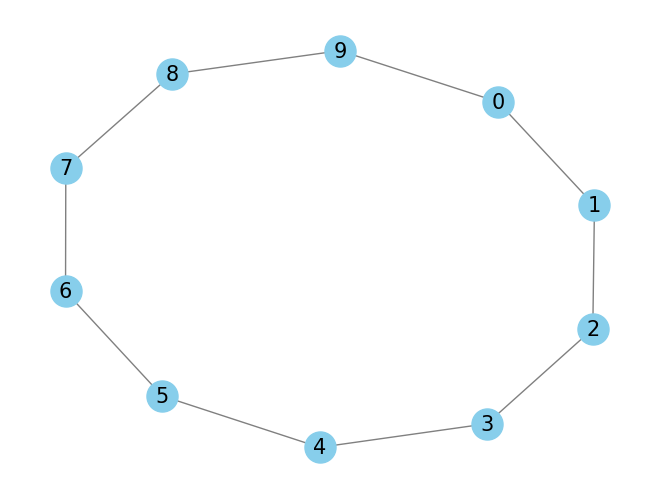

In [2]:
# Visualization of the graph
def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()

plot_graph(edge_index, num_nodes)

### What are RNNs?
- **Basic RNNs**: Traditional RNNs have a simple structure where each neuron passes its output to the next time step.
- **Limitations**: They struggle to capture long-term dependencies in sequences due to the vanishing gradient problem.

### LSTM RNNS
- **Purpose**: LSTMs were designed to address the vanishing gradient problem in traditional RNNs.
- **Architecture**: LSTMs have a more complex architecture with a cell state that allows information to flow across time steps.
- **Gates**: They use three gates (input, forget, and output) to control the flow of information.

### LSTM RNN Architecture
- **Input Gate**: Controls how much information from the current input should be used to update the cell state.
- **Forget Gate**: Controls how much of the previous cell state should be forgotten.
- **Output Gate**: Controls how much of the cell state should be exposed as the output.

### Advantages
- **Backpropagation Through Time (BPTT)**: LSTMs are trained using BPTT, which involves updating weights based on the error calculated across multiple time steps.
- **Gradient Clipping**: To prevent exploding gradients, gradient clipping is often used to limit the size of gradients during training.

In [3]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, num_timesteps, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.gcn2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.view(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.view(batch_size, num_timesteps, -1)
        
        # Apply LSTM for temporal modeling
        x, _ = self.lstm(x)
        
        # Apply GCN to the output of LSTM
        x = x.contiguous().view(batch_size * num_timesteps, -1)
        x = self.gcn2(x, edge_index)
        x = x.view(batch_size, num_timesteps, -1)
        
        return x

#### Setup the Problem with Simulated Time Series Traffic Data

- Initialize the number of nodes
- Time Steps
- NN architecture
- Setup the Simulated Data

What does the target mean?

- Future traffic conditions

In [4]:
# Initialize the model
num_nodes = 10
num_timesteps = 100
input_dim = 1
hidden_dim = 32
output_dim = 1
model = TemporalGNN(num_nodes, num_timesteps, input_dim, hidden_dim, output_dim)

# Simulate target data for training
y = torch.rand(num_nodes, num_timesteps, output_dim)
data.y = y

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(200):
    # Reset Gradient
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.2988440990447998
Epoch 20, Loss: 0.0842318907380104
Epoch 40, Loss: 0.08074329793453217
Epoch 60, Loss: 0.08026645332574844
Epoch 80, Loss: 0.08018425107002258
Epoch 100, Loss: 0.08016213774681091
Epoch 120, Loss: 0.0801439955830574
Epoch 140, Loss: 0.08012612909078598
Epoch 160, Loss: 0.08010836690664291
Epoch 180, Loss: 0.08008924871683121


### Visually display how the nodes have evolved over time

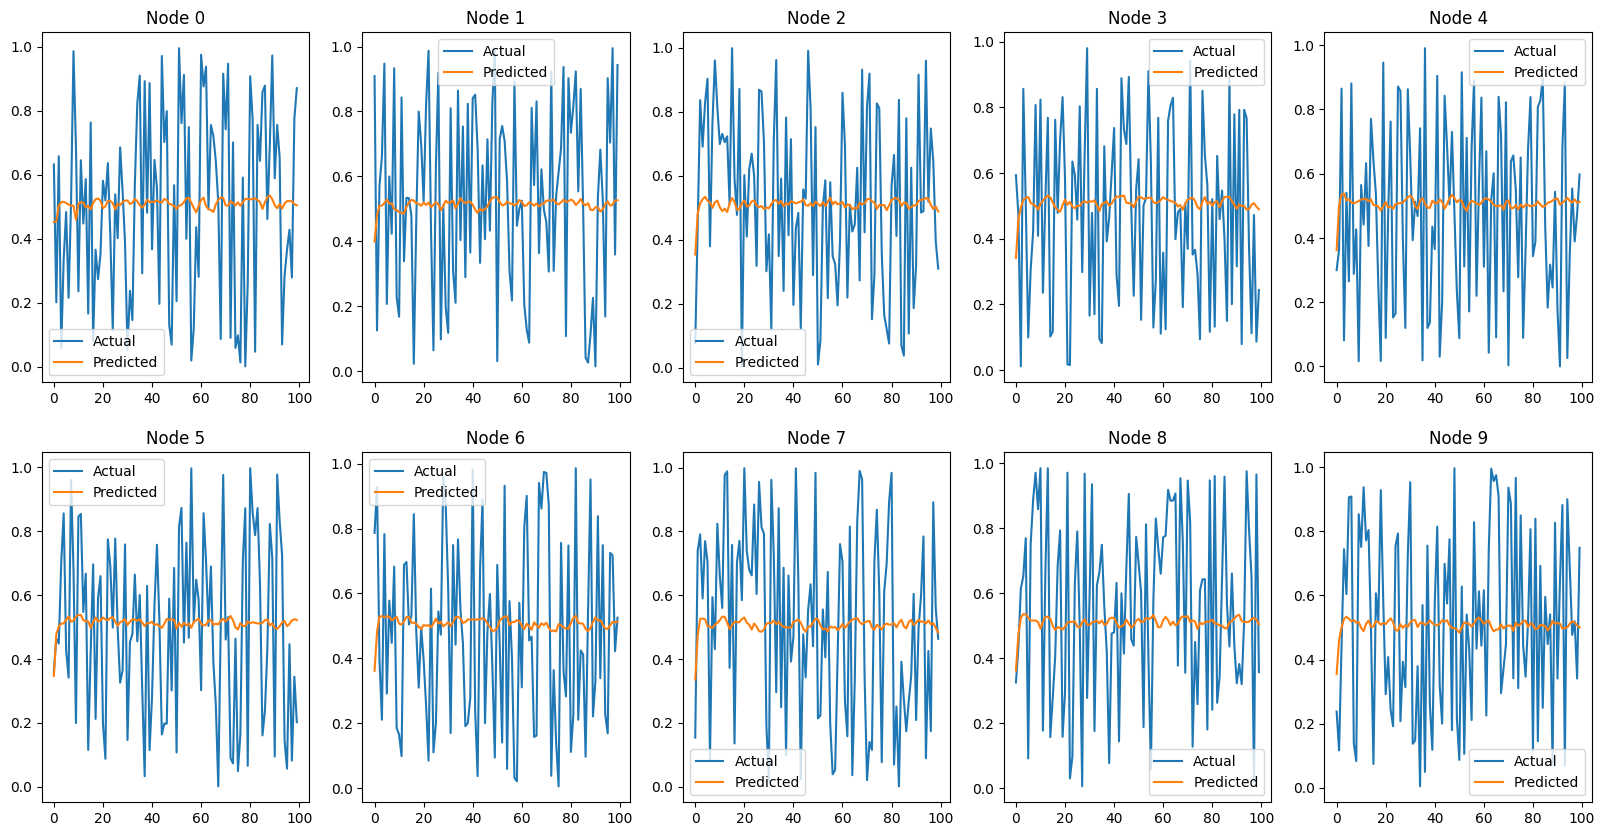

In [5]:
# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(out[i, :, 0].numpy(), label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()


As you can see the performance looks very bad so we have Gen AI change up the model a bit
- Add in a sine wave to better show real world data (simulated data changed)
- Increased the LSTM layers and added in another GCN for better capacity
- Increased Training Epochs to 500
- Learning Rate reduced to 0.001 for better convergence

# Using GNN on simple Traffic data [UPDATED]

In [6]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Simulate more structured traffic data: 10 nodes (e.g., sensors) with 100 time steps
num_nodes = 10
num_timesteps = 100

# Generate time series data with a pattern
time_series_data = np.sin(np.linspace(0, 100, num_timesteps)).reshape(-1, 1) + np.random.randn(num_timesteps, num_nodes) * 0.1

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Create data object
data = Data(x=x, edge_index=edge_index)


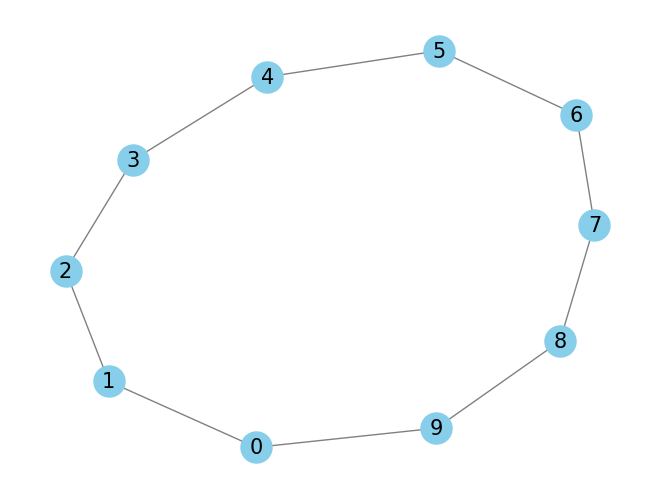

In [7]:
plot_graph(edge_index, num_nodes)

In [8]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, num_timesteps, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gcn3 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.view(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.view(batch_size, num_timesteps, -1)
        
        # Apply LSTM for temporal modeling
        x, _ = self.lstm(x)
        
        # Apply GCN to the output of LSTM
        x = x.contiguous().view(batch_size * num_timesteps, -1)
        x = F.relu(self.gcn2(x, edge_index))
        x = self.gcn3(x, edge_index)
        x = x.view(batch_size, num_timesteps, -1)
        
        return x

In [9]:
# Initialize the model
input_dim = 1
hidden_dim = 32
output_dim = 1
model = TemporalGNN(num_nodes, num_timesteps, input_dim, hidden_dim, output_dim)

# Simulate target data for training
y = torch.sin(torch.linspace(0, 100, num_timesteps)).reshape(-1, 1) + torch.randn(num_timesteps, num_nodes) * 0.1
y = y.t().contiguous().view(num_nodes, num_timesteps, 1)
data.y = y

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

Epoch 0, Loss: 0.5126954317092896
Epoch 50, Loss: 0.038109589368104935
Epoch 100, Loss: 0.017887089401483536
Epoch 150, Loss: 0.016566790640354156
Epoch 200, Loss: 0.015717623755335808
Epoch 250, Loss: 0.015071847476065159
Epoch 300, Loss: 0.014495563693344593
Epoch 350, Loss: 0.013997814618051052
Epoch 400, Loss: 0.013607501983642578
Epoch 450, Loss: 0.01327336486428976


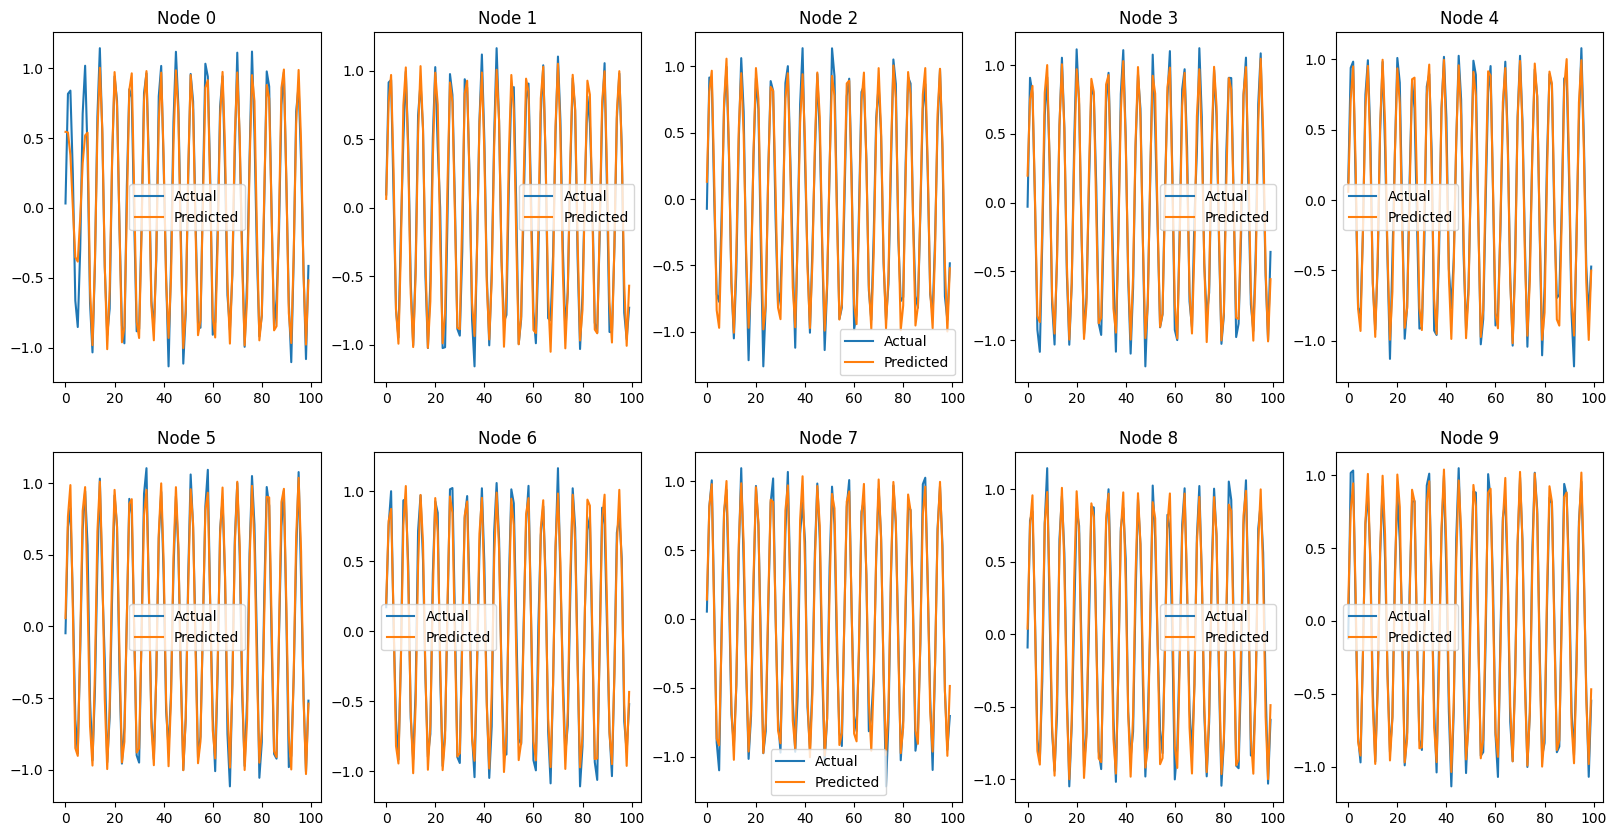

In [10]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(out[i, :, 0].numpy(), label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

This mimics better performance for the aforementioned reasons

# Using Gen AI on map data

torch
torch_geometric
networkx
matplotlib
numpy
pandas
pyyaml
osmnx
folium

In [11]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
import osmnx as ox
import networkx as nx
import numpy as np


# Get the road network of downtown Vancouver
place_name = "Downtown, Vancouver, British Columbia, Canada"
G = ox.graph_from_place(place_name, network_type='drive')

# Get the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)
G = G.subgraph(largest_scc).copy()

# Check if the graph is already simplified
if "simplified" not in G.graph or not G.graph["simplified"]:
    # Simplify the graph
    G = ox.simplify_graph(G)


In [12]:
# Get the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Simulate traffic data: 100 time steps of traffic flow data for each edge
num_timesteps = 100
traffic_data =  np.random.rand(num_timesteps, num_nodes)

# Get edge index
edges = list(G.edges)
edge_index = np.array([[list(G.nodes).index(edge[0]), list(G.nodes).index(edge[1])] for edge in edges]).T


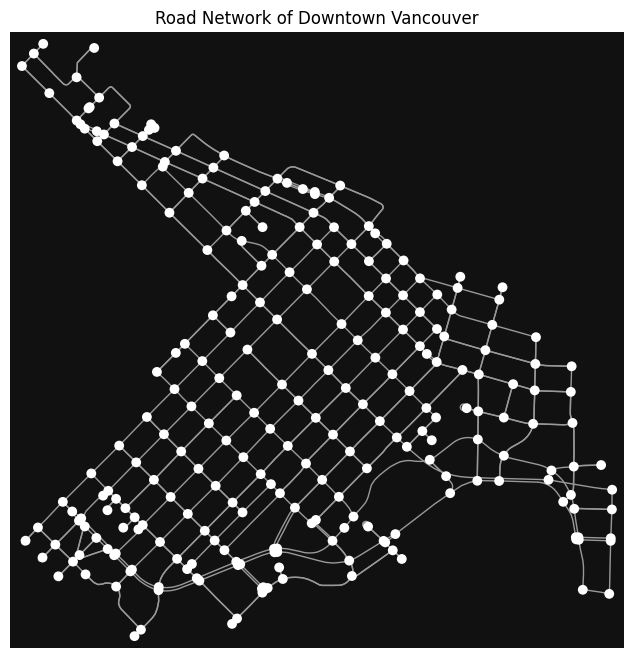

In [22]:
import matplotlib.pyplot as plt

# Plot the graph on Vancouver's map
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=50)
plt.title("Road Network of Downtown Vancouver")
plt.show()


In [14]:
from ipyleaflet import Map, basemaps, basemap_to_tiles

# Create a map centered around downtown Vancouver
center = (49.2827, -123.1207)
zoom = 13
m = Map(center=center, zoom=zoom)

# Add a satellite basemap
satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(satellite_layer)

# Display the map
m


Map(center=[49.2827, -123.1207], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [15]:
import torch
from torch_geometric.data import Data

# Convert traffic data to PyTorch tensor
x = torch.tensor(traffic_data, dtype=torch.float)

# Convert edge index to PyTorch tensor
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Create data object
data = Data(x=x, edge_index=edge_index)


In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class TrafficGNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super(TrafficGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
input_dim = num_timesteps
output_dim = num_timesteps
model = TrafficGNN(input_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 200 epochs
for epoch in range(200):
    loss = train()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')


RuntimeError: index 122 is out of bounds for dimension 0 with size 100

In [ ]:
import matplotlib.pyplot as plt

# Plot the original and predicted traffic flow for a random edge
random_edge = np.random.choice(num_edges)
original_flow = data.x[random_edge].detach().numpy()
predicted_flow = model(data)[random_edge].detach().numpy()

plt.plot(original_flow, label='Original')
plt.plot(predicted_flow, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Traffic Flow')
plt.legend()
plt.title('Traffic Flow Prediction')
plt.show()

Why is the prediction so underwhelming:

1. **Increase Model Capacity**: Try increasing the hidden dimension size and/or the number of layers in your GNN to allow the model to capture more complex patterns in the data.

2. **Adjust Learning Rate**: Experiment with different learning rates to find the one that works best for your model. Sometimes a smaller learning rate can lead to better convergence.

3. **Use Different Activation Functions**: Instead of using ReLU activation, try other activation functions like Leaky ReLU, ELU, or GELU to see if they improve performance.

4. **Regularization**: Add L2 regularization to the weights of your model to prevent overfitting. You can do this by adding the weight_decay parameter to your optimizer.

5. **Gradient Clipping**: Implement gradient clipping to prevent exploding gradients, which can sometimes lead to poor performance.

6. **Feature Engineering**: Consider adding more features to your input data that could help improve the model's ability to predict traffic flow.

7. **Hyperparameter Tuning**: Experiment with different hyperparameters such as batch size, dropout rate, and number of epochs to find the best combination for your model.

8. **Data Preprocessing**: Ensure that your data is properly preprocessed and normalized before training the model. This can have a significant impact on performance.

9. **Model Evaluation**: Use appropriate evaluation metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) to evaluate the performance of your model and compare it with the actual traffic flow data.

10. **Advanced Techniques**: Consider using more advanced techniques such as graph attention networks (GATs) or graph convolutional LSTM networks (GC-LSTM) for better performance on spatial-temporal data like traffic flow.

## TODO: Add a Spatial-temporal Lag using an AR(p) process

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_nodes = 10
num_timesteps = 100
p = 3  # Order of the AR process

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Generate AR(p) time series data with spatio-temporal lag
time_series_data = np.zeros((num_timesteps, num_nodes))

# AR coefficients
ar_coeffs = np.random.rand(p)

# Initial values
time_series_data[:p] = np.random.rand(p, num_nodes)

# Generate data
for t in range(p, num_timesteps):
    for i in range(num_nodes):
        temporal_component = sum(ar_coeffs[j] * time_series_data[t - j - 1, i] for j in range(p))
        spatial_component = sum(time_series_data[t - 1, (i + k) % num_nodes] for k in range(-1, 2) if k != 0) / 2
        time_series_data[t, i] = temporal_component + spatial_component + np.random.randn() * 0.1

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Normalize the input data
x = (x - x.mean()) / x.std()

# Create data object
data = Data(x=x, edge_index=edge_index)

# Split data into train and test sets
train_ratio = 0.8
num_train = int(num_timesteps * train_ratio)
train_x = x[:, :num_train, :]
test_x = x[:, num_train:, :]

train_data = Data(x=train_x, edge_index=edge_index)
test_data = Data(x=test_x, edge_index=edge_index)

# Define the GNN model with LSTM
class TrafficGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TrafficGNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
input_dim = 1
hidden_dim = 16
output_dim = 1
model = TrafficGNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Reduce learning rate
criterion = nn.MSELoss()

# Training setup with gradient clipping
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x[:, -1, :])
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    return loss.item()

# Evaluation setup
def evaluate(data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out, data.x[:, -1, :])
    return loss.item(), out

# Train and evaluate the model
num_epochs = 200
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(train_data)
    test_loss, _ = evaluate(test_data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 10, Train Loss: 0.0057, Test Loss: 77.4466
Epoch 20, Train Loss: 0.0001, Test Loss: 77.7524
Epoch 30, Train Loss: 0.0005, Test Loss: 77.8624
Epoch 40, Train Loss: 0.0000, Test Loss: 77.7087
Epoch 50, Train Loss: 0.0001, Test Loss: 77.6580
Epoch 60, Train Loss: 0.0000, Test Loss: 77.7234
Epoch 70, Train Loss: 0.0000, Test Loss: 77.7351
Epoch 80, Train Loss: 0.0000, Test Loss: 77.7109
Epoch 90, Train Loss: 0.0000, Test Loss: 77.7161
Epoch 100, Train Loss: 0.0000, Test Loss: 77.7236
Epoch 110, Train Loss: 0.0000, Test Loss: 77.7185
Epoch 120, Train Loss: 0.0000, Test Loss: 77.7186
Epoch 130, Train Loss: 0.0000, Test Loss: 77.7204
Epoch 140, Train Loss: 0.0000, Test Loss: 77.7193
Epoch 150, Train Loss: 0.0000, Test Loss: 77.7194
Epoch 160, Train Loss: 0.0000, Test Loss: 77.7197
Epoch 170, Train Loss: 0.0000, Test Loss: 77.7195
Epoch 180, Train Loss: 0.0000, Test Loss: 77.7196
Epoch 190, Train Loss: 0.0000, Test Loss: 77.7196
Epoch 200, Train Loss: 0.0000, Test Loss: 77.7195


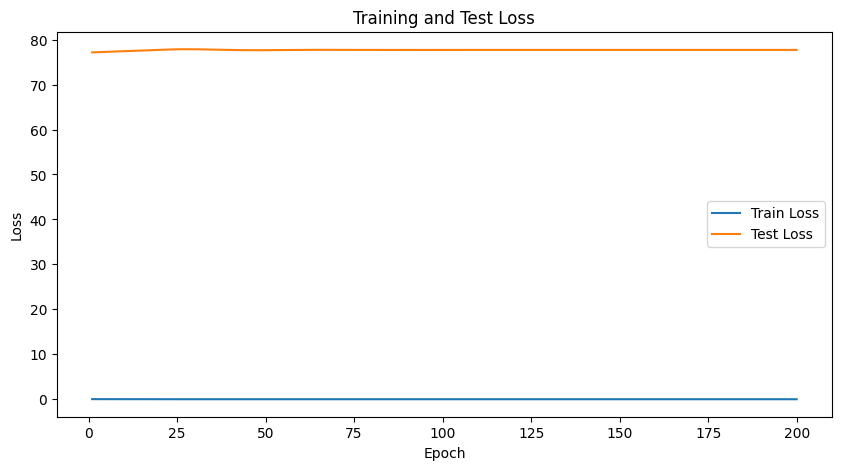

In [20]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()



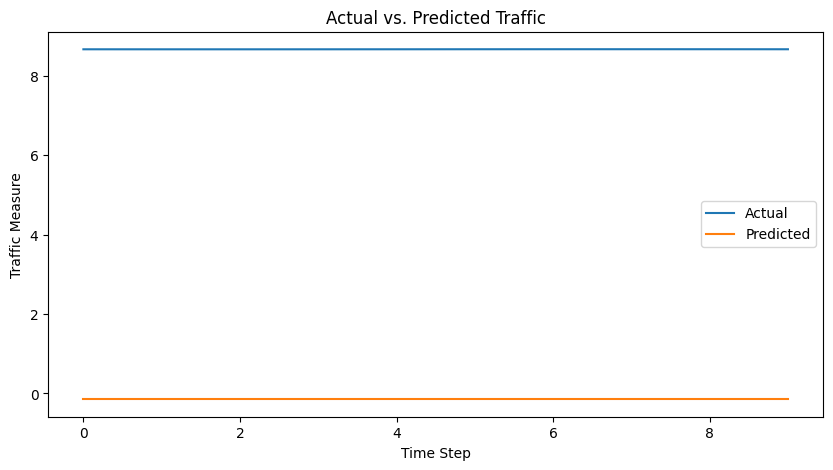

In [21]:
# Plot actual vs. predicted values
test_loss, test_predictions = evaluate(test_data)
test_predictions = test_predictions.cpu().numpy()
actual_values = test_data.x[:, -1, :].cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(actual_values.flatten(), label='Actual')
plt.plot(test_predictions.flatten(), label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Traffic Measure')
plt.legend()
plt.title('Actual vs. Predicted Traffic')
plt.show()

Features are previous time point and we capture this in nodes using lag

# GNN on simple model (no temporal GNN)

## Causal analysis in the nodes - display this visually